# Robot Vision Notebook (COMP34212)

##### Misc

In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-04-17 12:04:22.559228: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 12:04:22.585905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 12:04:22.585926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 12:04:22.586576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 12:04:22.590820: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.keras.backend.clear_session()
tf.config.run_functions_eagerly(True)

### Global Constants & Variables

In [3]:
# Image
IMAGES_PATH = "icub"
IMG_CHANNELS = 3
IMG_DOWNSCALE_FACTOR = 4
IMG_ROWS = int(256/IMG_DOWNSCALE_FACTOR)
IMG_COLS = int(256/IMG_DOWNSCALE_FACTOR)
N_CLASSES = len(os.listdir(IMAGES_PATH))

# Training
BATCH_SIZE = 32 
N_EPOCH = 25
VERBOSE = 1
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001
OPTIM = Adam(LEARNING_RATE)

### Data Pre-Processing

In [4]:
# Get number of classes and map from strings to integers
objects = os.listdir(IMAGES_PATH)
mapping = {object_name: object_index for object_index, object_name in enumerate(objects)}
print(mapping)

{'ringbinder': 0, 'hairclip': 1, 'pencilcase': 2, 'wallet': 3, 'cellphone': 4, 'book': 5, 'hairbrush': 6, 'perfume': 7, 'sunglasses': 8, 'mouse': 9}


In [5]:
# Input images
image_dataset_x = []
image_dataset_y = []

def load_images(path, downscale_factor):
    """Cycles through folder structure inputting images and classifications to x and y lists and downsamples image by given factor"""
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            # Avoids listed folders and continues searching
            if item_path.split("/")[-1] not in ["ROT2D", "ROT3D", "SCALE", "TRANSL", "right"]: # folders to avoid
                load_images(item_path, downscale_factor)
        else:
            # If not a folder, checks for 26x256 jpg, downsamples, saves to x and y
            if item_path.endswith(".jpg"):
                image = cv2.imread(item_path)
                if image.shape == (256, 256, 3):
                    downsampled_image = cv2.resize(image, None, fx=1/downscale_factor, fy=1/downscale_factor)
                    image_dataset_x.append(downsampled_image)
                    category = item_path.split("/")[1] # swap to "\\" if using windows
                    image_dataset_y.append(mapping.get(category))
                    print(item_path)

load_images(IMAGES_PATH, IMG_DOWNSCALE_FACTOR)

icub/ringbinder/ringbinder7/MIX/day4/left/00001618.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001627.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001762.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001661.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001632.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001675.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001788.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001596.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001595.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001552.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001636.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001725.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001574.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001644.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001704.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001581.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001735.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001589.jpg
icub/ringb

In [6]:
# Convert lists into np.arrays
image_dataset_x = np.array(image_dataset_x)
image_dataset_y = np.array(image_dataset_y)

In [7]:
# Print shapes of both np arrays
print(image_dataset_x.shape)
print(image_dataset_y.shape)

(61045, 64, 64, 3)
(61045,)


In [8]:
# Print distribution of classes
counts = np.unique(image_dataset_y, return_counts=True)
for i in range(N_CLASSES):
    print(f"{list(mapping.keys())[i]}: {counts[1][i]}")

ringbinder: 5363
hairclip: 6736
pencilcase: 6734
wallet: 5410
cellphone: 5718
book: 6666
hairbrush: 6186
perfume: 6294
sunglasses: 5426
mouse: 6512


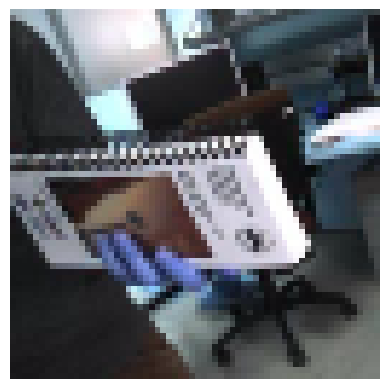

In [9]:
# Display sample image
plt.imshow(image_dataset_x[0])
plt.axis('off') 
plt.show()

In [10]:
# Split dataset into training and testing
input_X_train, input_X_test, output_y_train, output_y_test = train_test_split(image_dataset_x, image_dataset_y, test_size=0.2, random_state=42, stratify=image_dataset_y)

In [11]:
# Deletes extra sets from memory
del image_dataset_x
del image_dataset_y

In [12]:
# One-hot encode
output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES) 

In [13]:
# Deletes extra sets from memory
del output_y_train
del output_y_test

In [14]:
# Normalise images
input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255

In [15]:
print(input_X_train.shape)

(48836, 64, 64, 3)


### Functions

In [16]:
def model_evaluation(model, history):
    score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print("\nTest score/loss:", score[0])
    print('Test accuracy:', score[1])

    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    return score[1]

### Standard Test

In [ ]:
# Complex DNN model definition
model = Sequential()
 
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))


#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                        

2024-04-15 20:55:12.965064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 20:55:12.985974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 20:55:12.986101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [20]:
# Training/fitting of the DNN model
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5


2024-04-15 20:55:17.321613: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-15 20:55:17.364829: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 20:55:17.545530: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 29s 23ms/step - loss: 1.5967 - accuracy: 0.4232 - val_loss: 0.9815 - val_accuracy: 0.6502
Epoch 2/5
1221/1221 [==============================] - 26s 21ms/step - loss: 0.8971 - accuracy: 0.6762 - val_loss: 0.6576 - val_accuracy: 0.7673
Epoch 3/5
1221/1221 [==============================] - 25s 21ms/step - loss: 0.6544 - accuracy: 0.7640 - val_loss: 0.4574 - val_accuracy: 0.8394
Epoch 4/5
1221/1221 [==============================] - 25s 21ms/step - loss: 0.5247 - accuracy: 0.8122 - val_loss: 0.4093 - val_accuracy: 0.8614
Epoch 5/5
1221/1221 [==============================] - 25s 21ms/step - loss: 0.4631 - accuracy: 0.8359 - val_loss: 0.3440 - val_accuracy: 0.8854


In [ ]:
model_evaluation(model, history)

In [21]:
# Calculates testing predictions
predictions = model.predict(input_X_test)

382/382 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'Correlation Matrix')

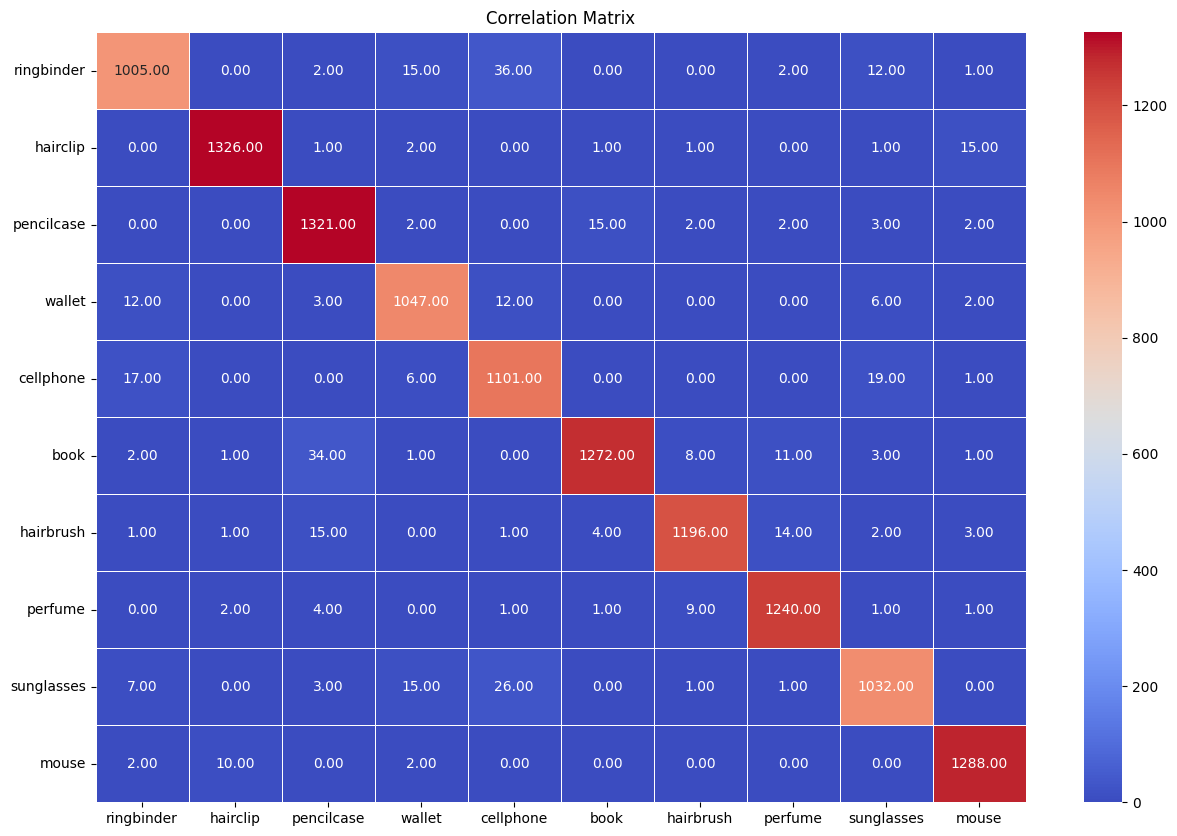

In [22]:
# Calculates and displays confusion matrix
cm = confusion_matrix(np.argmax(output_Y_test, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, xticklabels=objects, yticklabels=objects) 
plt.yticks(rotation=0)
plt.title('Correlation Matrix')

### Network Topology Experimentation

##### LeNet

In [25]:
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()

		# CONV => RELU => POOL
		model.add(Conv2D(20, kernel_size=5, padding="same", input_shape=input_shape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

		# CONV => RELU => POOL
		model.add(Conv2D(50, kernel_size=5, padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))

		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

In [17]:
model = LeNet.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 20)        1520      
                                                                 
 activation (Activation)     (None, 64, 64, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 20)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 50)        0         
 g2D)                                                   

2024-04-16 12:07:07.376574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 12:07:07.401267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 12:07:07.401392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 12:07:13.609886: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 12:07:13.647670: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 12:07:13.845750: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 20s 15ms/step - loss: 1.2632 - accuracy: 0.5482 - val_loss: 0.7944 - val_accuracy: 0.7167
Epoch 2/25
1221/1221 [==============================] - 18s 15ms/step - loss: 0.4593 - accuracy: 0.8427 - val_loss: 0.5109 - val_accuracy: 0.8317
Epoch 3/25
1221/1221 [==============================] - 18s 15ms/step - loss: 0.1725 - accuracy: 0.9424 - val_loss: 0.4507 - val_accuracy: 0.8597
Epoch 4/25
1221/1221 [==============================] - 18s 14ms/step - loss: 0.0820 - accuracy: 0.9726 - val_loss: 0.5768 - val_accuracy: 0.8507
Epoch 5/25
1221/1221 [==============================] - 17s 14ms/step - loss: 0.0584 - accuracy: 0.9805 - val_loss: 0.6134 - val_accuracy: 0.8640
Epoch 6/25
1221/1221 [==============================] - 18s 14ms/step - loss: 0.0543 - accuracy: 0.9814 - val_loss: 0.6535 - val_accuracy: 0.8632
Epoch 7/25
1221/1221 [==============================] - 17s 14ms/step - loss: 0.0490 - accuracy: 0.9847 - val_loss: 0.6939 - val_accura

382/382 [==============================] - 3s 8ms/step - loss: 1.3725 - accuracy: 0.8629

Test score/loss: 1.3725382089614868
Test accuracy: 0.8628880381584167
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


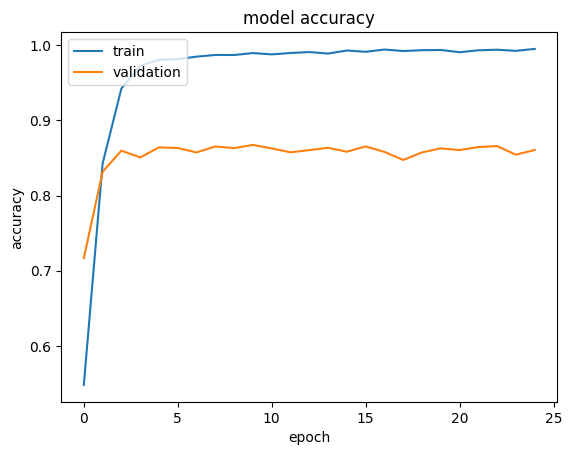

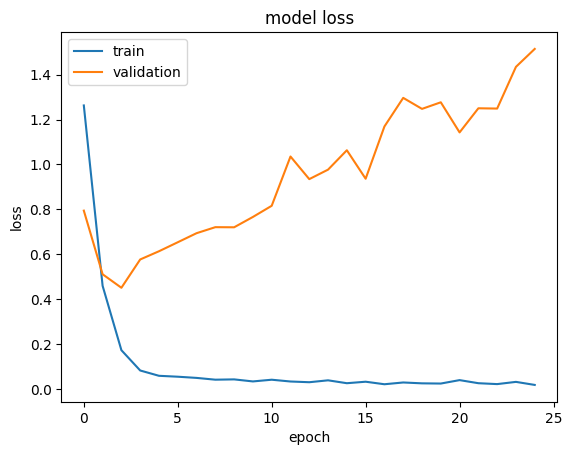

In [22]:
model_evaluation(model)

##### AlexNet (Standard)

In [17]:
class AlexNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()

		model.add(Conv2D(96, kernel_size=11, strides=(4, 4), activation="ReLU", padding="valid", input_shape=input_shape))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(256, kernel_size=5, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(384, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(384, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(384, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))

		model.add(Flatten())
		model.add(Dense(4096, activation="ReLU"))
		model.add(Dense(4096, activation="ReLU"))
		model.add(Dense(classes, activation="softmax"))

		return model

In [18]:
model = AlexNet.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()


2024-04-16 16:07:51.881771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:07:51.901371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:07:51.901501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 96)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 384)         1

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 16:07:53.295656: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 16:07:53.337270: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 16:07:53.493422: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 26s 20ms/step - loss: 2.2997 - accuracy: 0.1092 - val_loss: 2.2993 - val_accuracy: 0.1080
Epoch 2/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2991 - accuracy: 0.1083 - val_loss: 2.2995 - val_accuracy: 0.1070
Epoch 3/25
1221/1221 [==============================] - 24s 19ms/step - loss: 2.2988 - accuracy: 0.1093 - val_loss: 2.2996 - val_accuracy: 0.1070
Epoch 4/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2988 - accuracy: 0.1094 - val_loss: 2.2996 - val_accuracy: 0.1070
Epoch 5/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2988 - accuracy: 0.1079 - val_loss: 2.2993 - val_accuracy: 0.1070
Epoch 6/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2987 - accuracy: 0.1096 - val_loss: 2.2994 - val_accuracy: 0.1070
Epoch 7/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2987 - accuracy: 0.1099 - val_loss: 2.2992 - val_accura

382/382 [==============================] - 4s 10ms/step - loss: 2.2986 - accuracy: 0.1103

Test score/loss: 2.298635244369507
Test accuracy: 0.11032844334840775
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


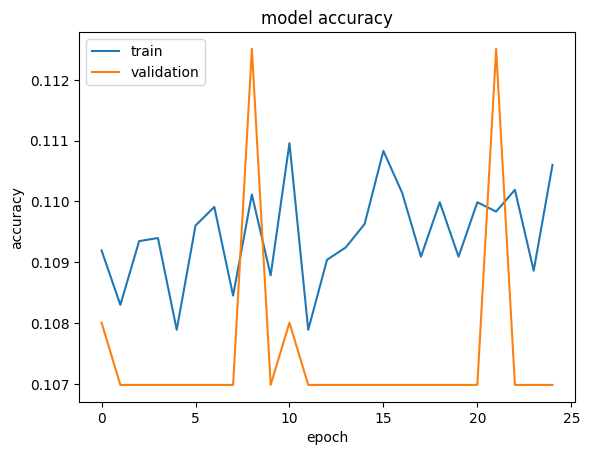

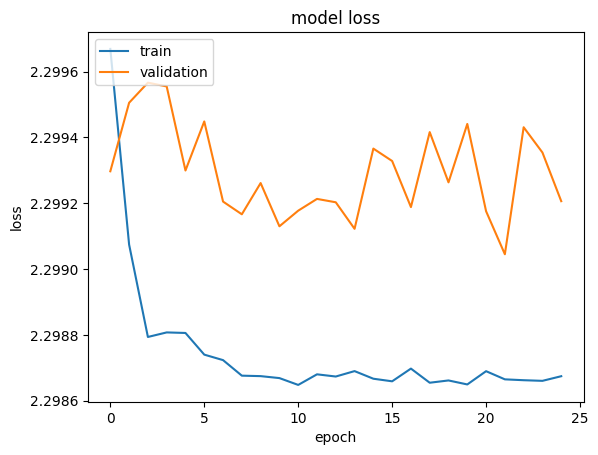

In [20]:
model_evaluation(model)

##### AlexNet Modified

In [17]:
class AlexNetModified:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()

		model.add(Conv2D(32, kernel_size=11, strides=(4, 4), activation="ReLU", padding="valid", input_shape=input_shape))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(64, kernel_size=5, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(96, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(96, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(96, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))

		model.add(Flatten())
		model.add(Dense(512, activation="ReLU"))
		model.add(Dense(512, activation="ReLU"))
		model.add(Dense(classes, activation="softmax"))

		return model

In [18]:
model = AlexNetModified.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        11648     
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 96)          55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 96)          8

2024-04-16 15:12:21.709677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:12:21.730543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:12:21.730661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 15:12:24.778314: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 15:12:24.815418: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 15:12:24.964614: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 25s 20ms/step - loss: 1.9128 - accuracy: 0.2800 - val_loss: 1.5470 - val_accuracy: 0.4087
Epoch 2/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.3641 - accuracy: 0.4890 - val_loss: 1.2694 - val_accuracy: 0.5349
Epoch 3/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.0726 - accuracy: 0.6044 - val_loss: 1.0640 - val_accuracy: 0.6247
Epoch 4/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.8864 - accuracy: 0.6769 - val_loss: 0.9051 - val_accuracy: 0.6745
Epoch 5/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.7434 - accuracy: 0.7322 - val_loss: 0.8244 - val_accuracy: 0.6996
Epoch 6/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.6330 - accuracy: 0.7761 - val_loss: 0.7512 - val_accuracy: 0.7379
Epoch 7/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.5509 - accuracy: 0.8063 - val_loss: 0.7068 - val_accura

382/382 [==============================] - 4s 9ms/step - loss: 0.7117 - accuracy: 0.8283

Test score/loss: 0.7117161154747009
Test accuracy: 0.8283233642578125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


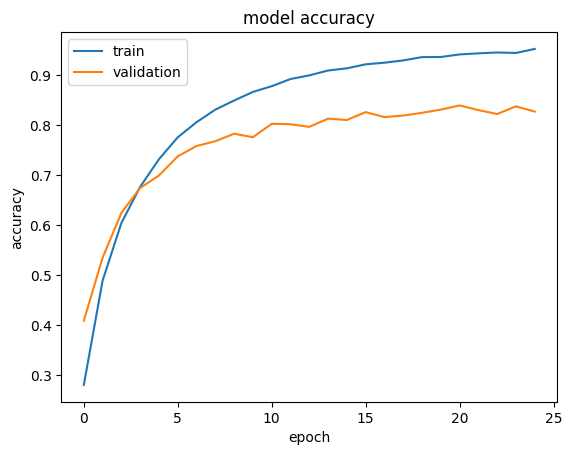

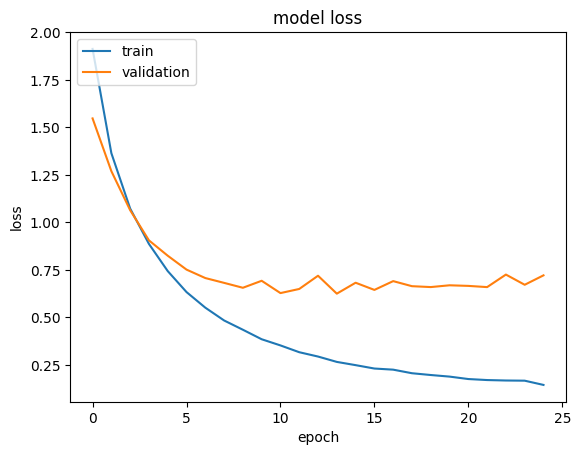

In [20]:
model_evaluation(model)

##### Deep CNN

In [17]:
class DeepCNN:
        @staticmethod
        def build(input_shape, classes, kernel_size=3, dropout=0):
                model = Sequential()
                
                model.add(Conv2D(32, kernel_size=kernel_size, padding='same', input_shape=input_shape))
                model.add(Activation('relu'))
                model.add(Conv2D(32, kernel_size=kernel_size, padding='same'))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Dropout(dropout))

                model.add(Conv2D(64, kernel_size=kernel_size, padding='same'))
                model.add(Activation('relu'))
                model.add(Conv2D(64, 3, 3))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))
                model.add(Dropout(dropout))

                model.add(Flatten())
                model.add(Dense(512))
                model.add(Activation('relu'))
                model.add(Dropout(dropout))
                model.add(Dense(classes))
                model.add(Activation('softmax'))

                return model

In [18]:
model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                        

2024-04-16 15:43:42.679190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:43:42.698584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:43:42.698693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 15:43:44.186400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 15:43:44.225021: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 15:43:44.402199: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 23s 18ms/step - loss: 1.1706 - accuracy: 0.5812 - val_loss: 0.6056 - val_accuracy: 0.7819
Epoch 2/25
1221/1221 [==============================] - 21s 17ms/step - loss: 0.4286 - accuracy: 0.8504 - val_loss: 0.4078 - val_accuracy: 0.8577
Epoch 3/25
1221/1221 [==============================] - 20s 17ms/step - loss: 0.2222 - accuracy: 0.9227 - val_loss: 0.3324 - val_accuracy: 0.8916
Epoch 4/25
1221/1221 [==============================] - 20s 17ms/step - loss: 0.1403 - accuracy: 0.9528 - val_loss: 0.3945 - val_accuracy: 0.8793
Epoch 5/25
1221/1221 [==============================] - 20s 17ms/step - loss: 0.0971 - accuracy: 0.9670 - val_loss: 0.3107 - val_accuracy: 0.9123
Epoch 6/25
1221/1221 [==============================] - 21s 17ms/step - loss: 0.0823 - accuracy: 0.9722 - val_loss: 0.4153 - val_accuracy: 0.8897
Epoch 7/25
1221/1221 [==============================] - 20s 17ms/step - loss: 0.0670 - accuracy: 0.9782 - val_loss: 0.3242 - val_accura

382/382 [==============================] - 3s 9ms/step - loss: 0.4380 - accuracy: 0.9328

Test score/loss: 0.4379832446575165
Test accuracy: 0.9327545166015625
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


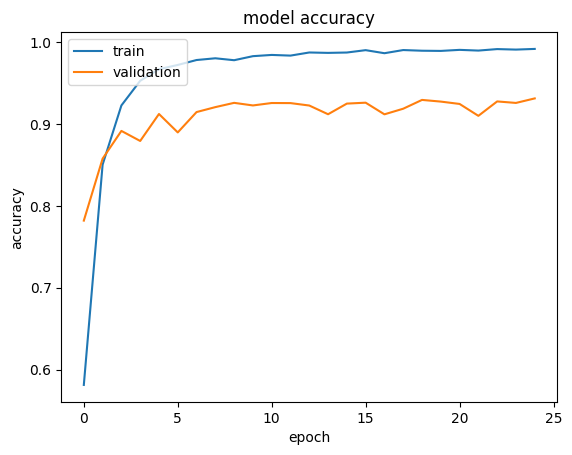

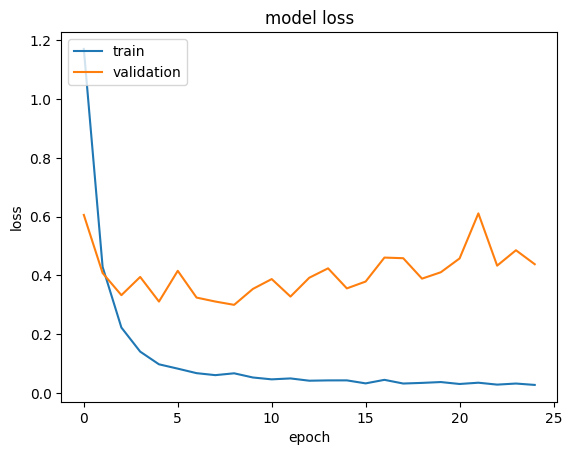

In [20]:
model_evaluation(model)

##### Simple CNN

In [17]:
class SimpleCNN:
        @staticmethod
        def build(input_shape, classes):
            model = Sequential()

            model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            # model.add(Dropout(0.25))
            
            model.add(Flatten())
            model.add(Dense(512))
            model.add(Activation('relu'))
            # model.add(Dropout(0.5))

            model.add(Dense(classes))
            model.add(Activation('softmax'))

            return model

In [19]:
model = SimpleCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                        

2024-04-16 16:00:09.151102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:00:09.171315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:00:09.171430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [20]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 16:00:11.403009: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 16:00:11.441441: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 16:00:11.624984: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 17s 13ms/step - loss: 1.3437 - accuracy: 0.5352 - val_loss: 0.8863 - val_accuracy: 0.6943
Epoch 2/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.5640 - accuracy: 0.8078 - val_loss: 0.6528 - val_accuracy: 0.7754
Epoch 3/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.2551 - accuracy: 0.9174 - val_loss: 0.6482 - val_accuracy: 0.7934
Epoch 4/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.1078 - accuracy: 0.9676 - val_loss: 0.6628 - val_accuracy: 0.8088
Epoch 5/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0651 - accuracy: 0.9810 - val_loss: 0.7945 - val_accuracy: 0.8010
Epoch 6/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0519 - accuracy: 0.9841 - val_loss: 0.8331 - val_accuracy: 0.8025
Epoch 7/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0422 - accuracy: 0.9861 - val_loss: 0.9260 - val_accura

382/382 [==============================] - 3s 7ms/step - loss: 1.8019 - accuracy: 0.7765

Test score/loss: 1.8019256591796875
Test accuracy: 0.7764763832092285
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


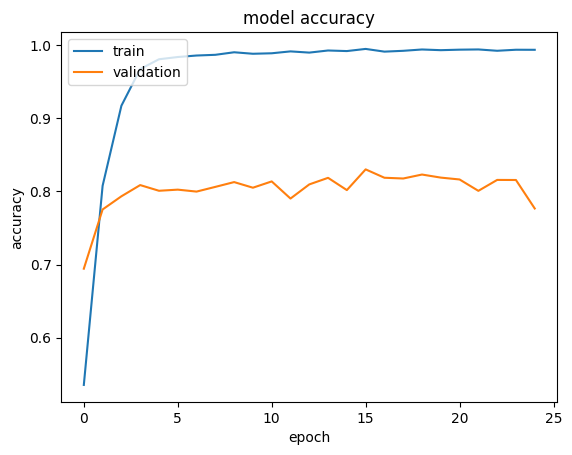

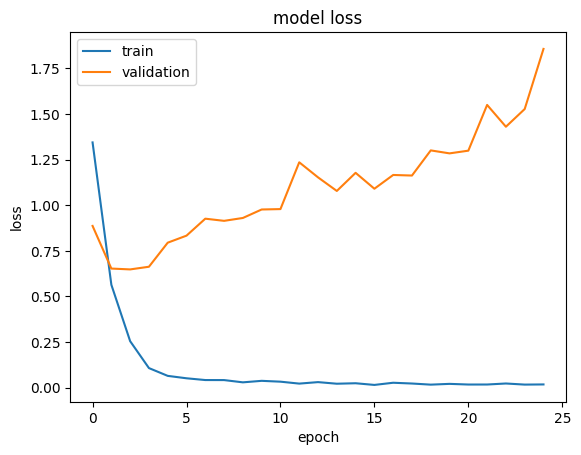

In [21]:
model_evaluation(model)

Try increasing number of layers

### Network Hyperparameters Experimentation (Deep CNN)

##### Dropout Percentage Testing (Run Separetly Due to GPU Memory Constraints)

In [19]:
# dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
# accuracy_list = []

# for dropout_percentage in dropouts:
#     print(f"DROPOUT PERCENTAGE: {dropout_percentage}\n")

#     model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=dropout_percentage)
#     model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
#     print(model.summary())

#     history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
#     accuracy = model_evaluation(model, history)
#     accuracy_list.append(accuracy)

DROPOUT PERCENTAGE: 0.1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                               

2024-04-16 17:48:59.941707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 17:48:59.960306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 17:48:59.960425: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 17:49:01.375927: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 17:49:01.416512: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 17:49:01.596561: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 21ms/step - loss: 1.2577 - accuracy: 0.5458 - val_loss: 0.6880 - val_accuracy: 0.7582
Epoch 2/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.5246 - accuracy: 0.8152 - val_loss: 0.3899 - val_accuracy: 0.8678
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3066 - accuracy: 0.8923 - val_loss: 0.3420 - val_accuracy: 0.8816
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2186 - accuracy: 0.9243 - val_loss: 0.2646 - val_accuracy: 0.9127
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.1625 - accuracy: 0.9438 - val_loss: 0.2638 - val_accuracy: 0.9163
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.1383 - accuracy: 0.9538 - val_loss: 0.2421 - val_accuracy: 0.9252
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.1085 - accuracy: 0.9635 - val_loss: 0.2623 - val_accura

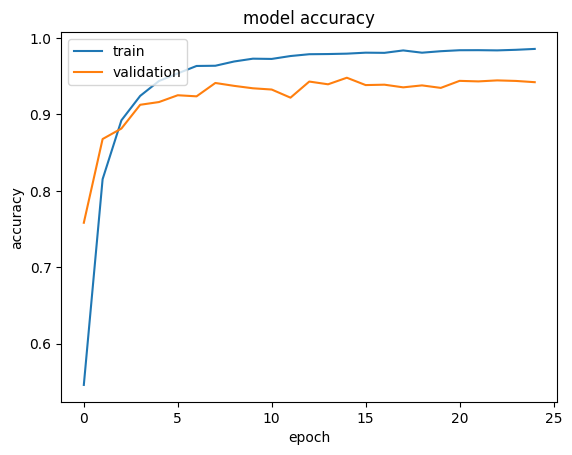

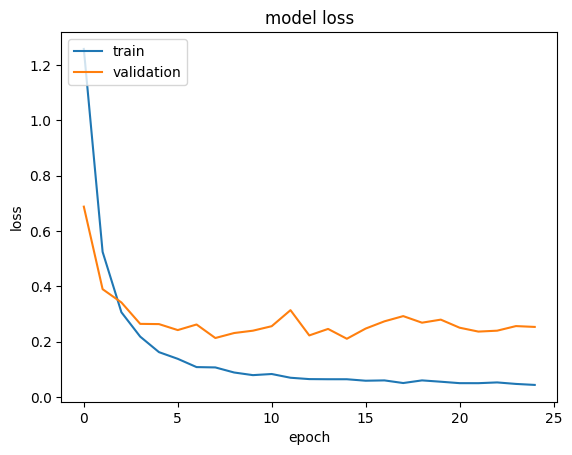

In [18]:
dropout_percentage = 0.1

print(f"DROPOUT PERCENTAGE: {dropout_percentage}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=dropout_percentage)
model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

DROPOUT PERCENTAGE: 0.2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                               

2024-04-16 17:14:44.673177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 17:14:44.695522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 17:14:44.695693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 17:14:46.144242: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 17:14:46.183134: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 17:14:46.356489: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 21ms/step - loss: 1.3289 - accuracy: 0.5210 - val_loss: 0.6930 - val_accuracy: 0.7542
Epoch 2/25
1221/1221 [==============================] - 24s 19ms/step - loss: 0.6055 - accuracy: 0.7870 - val_loss: 0.3933 - val_accuracy: 0.8720
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4039 - accuracy: 0.8578 - val_loss: 0.4098 - val_accuracy: 0.8616
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2949 - accuracy: 0.8974 - val_loss: 0.2480 - val_accuracy: 0.9167
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2405 - accuracy: 0.9175 - val_loss: 0.2206 - val_accuracy: 0.9276
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2033 - accuracy: 0.9295 - val_loss: 0.2117 - val_accuracy: 0.9297
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.1758 - accuracy: 0.9392 - val_loss: 0.2135 - val_accura

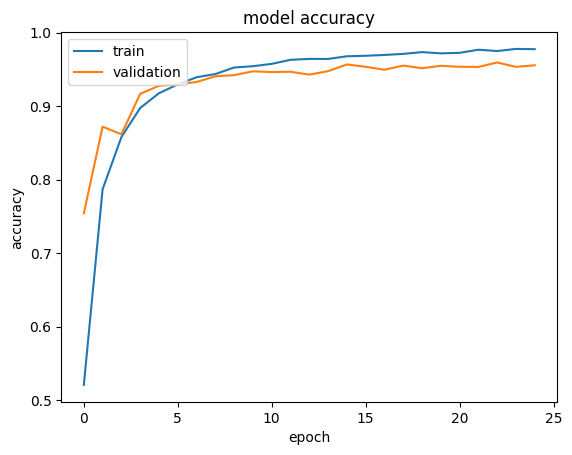

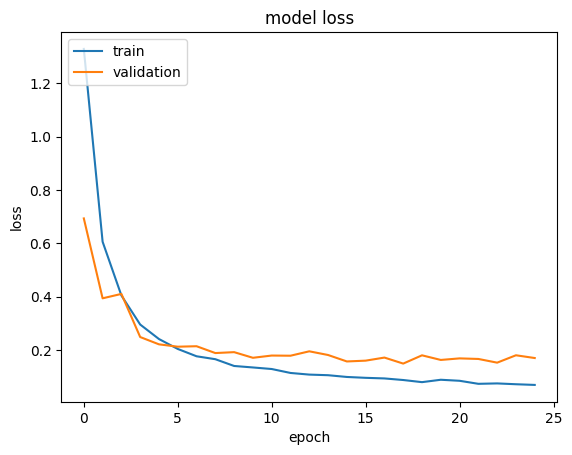

In [18]:
dropout_percentage = 0.2

print(f"DROPOUT PERCENTAGE: {dropout_percentage}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=dropout_percentage)
model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

DROPOUT PERCENTAGE: 0.3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                               

2024-04-16 17:26:10.339579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 17:26:10.361848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 17:26:10.362029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Trainable params: 890410 (3.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 17:26:11.752743: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 17:26:11.792356: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 17:26:11.979598: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 28s 21ms/step - loss: 1.6275 - accuracy: 0.4173 - val_loss: 1.0493 - val_accuracy: 0.6316
Epoch 2/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.9076 - accuracy: 0.6751 - val_loss: 0.5771 - val_accuracy: 0.8063
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.6110 - accuracy: 0.7819 - val_loss: 0.4311 - val_accuracy: 0.8512
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4698 - accuracy: 0.8356 - val_loss: 0.3451 - val_accuracy: 0.8827
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3950 - accuracy: 0.8615 - val_loss: 0.2677 - val_accuracy: 0.9084
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3264 - accuracy: 0.8848 - val_loss: 0.2665 - val_accuracy: 0.9104
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2985 - accuracy: 0.8977 - val_loss: 0.2490 - val_accura

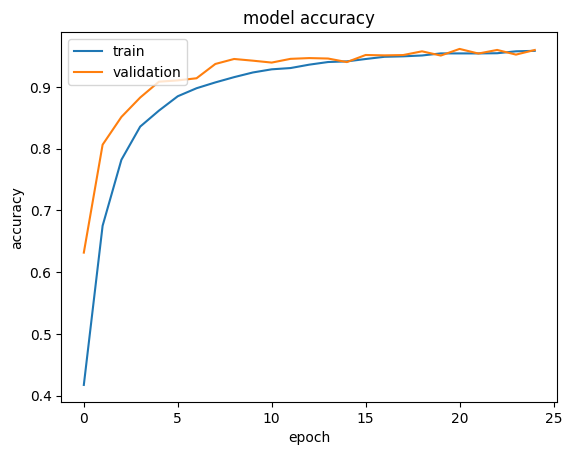

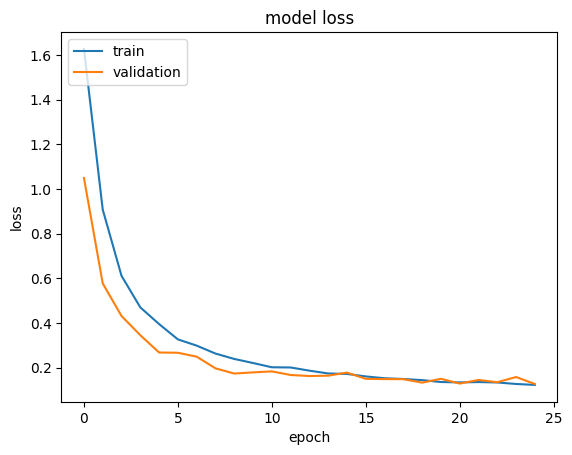

In [18]:
dropout_percentage = 0.3

print(f"DROPOUT PERCENTAGE: {dropout_percentage}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=dropout_percentage)
model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

DROPOUT PERCENTAGE: 0.4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                               

2024-04-16 17:37:23.331249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 17:37:23.351477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 17:37:23.351609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 17:37:24.732414: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 17:37:24.771055: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 17:37:24.953581: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 21ms/step - loss: 1.5919 - accuracy: 0.4245 - val_loss: 0.9756 - val_accuracy: 0.6578
Epoch 2/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.8973 - accuracy: 0.6765 - val_loss: 0.5966 - val_accuracy: 0.7938
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.6592 - accuracy: 0.7652 - val_loss: 0.4279 - val_accuracy: 0.8544
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.5365 - accuracy: 0.8082 - val_loss: 0.3497 - val_accuracy: 0.8774
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4576 - accuracy: 0.8399 - val_loss: 0.2842 - val_accuracy: 0.9044
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4010 - accuracy: 0.8582 - val_loss: 0.2738 - val_accuracy: 0.9108
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3641 - accuracy: 0.8700 - val_loss: 0.2499 - val_accura

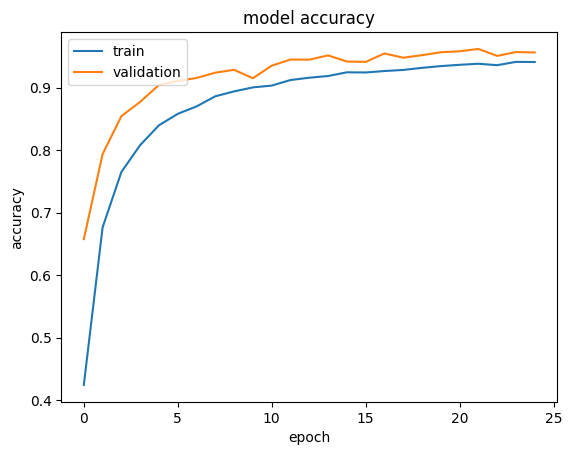

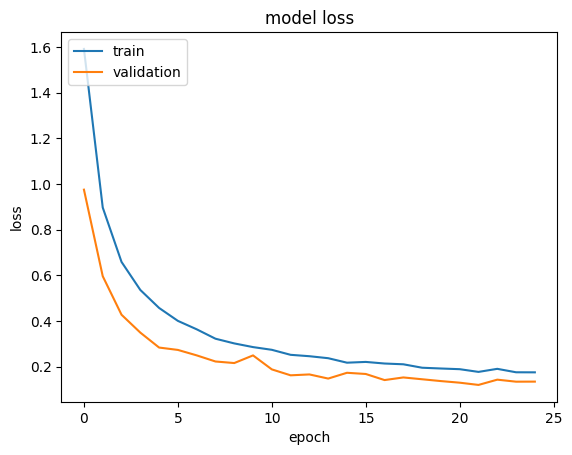

In [18]:
dropout_percentage = 0.4

print(f"DROPOUT PERCENTAGE: {dropout_percentage}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=dropout_percentage)
model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

DROPOUT PERCENTAGE: 0.5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                               

2024-04-16 18:01:06.332563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:01:06.351319: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:01:06.351458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 18:01:07.690028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 18:01:07.728345: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 18:01:07.922909: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 21ms/step - loss: 1.7397 - accuracy: 0.3654 - val_loss: 1.1433 - val_accuracy: 0.5914
Epoch 2/25
1221/1221 [==============================] - 24s 20ms/step - loss: 1.0978 - accuracy: 0.5995 - val_loss: 0.7295 - val_accuracy: 0.7473
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.8367 - accuracy: 0.6978 - val_loss: 0.5717 - val_accuracy: 0.8022
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.7034 - accuracy: 0.7458 - val_loss: 0.5184 - val_accuracy: 0.8362
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.6068 - accuracy: 0.7804 - val_loss: 0.4058 - val_accuracy: 0.8704
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.5478 - accuracy: 0.8012 - val_loss: 0.3457 - val_accuracy: 0.8935
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4951 - accuracy: 0.8249 - val_loss: 0.3101 - val_accura

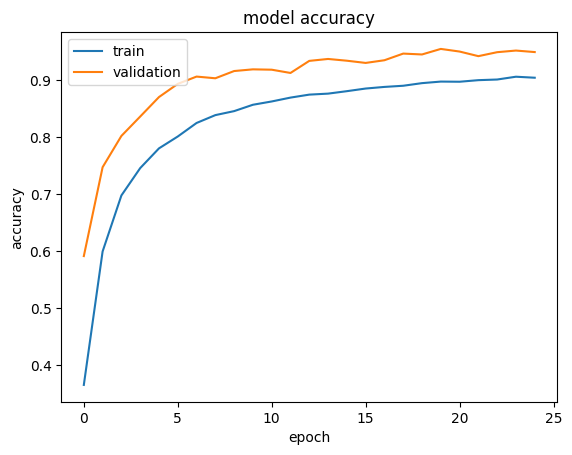

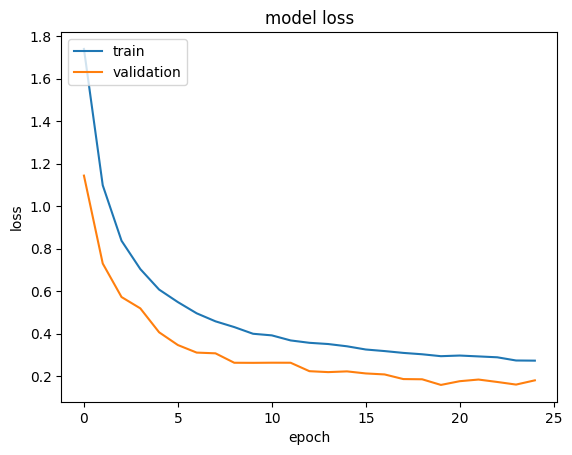

In [19]:
dropout_percentage = 0.5

print(f"DROPOUT PERCENTAGE: {dropout_percentage}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=dropout_percentage)
model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

##### Kernel Size Testing (Run Separetly Due to GPU Memory Constraints)

In [19]:
DROPOUT_PERCENTAGE = 0.3 # From testing

KERNEL SIZE: 3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                        

2024-04-17 11:47:54.076604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 11:47:54.098089: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 11:47:54.098219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-17 11:47:55.447750: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-17 11:47:55.484850: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 11:47:55.659148: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 20ms/step - loss: 1.5966 - accuracy: 0.4262 - val_loss: 0.9692 - val_accuracy: 0.6500
Epoch 2/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.8480 - accuracy: 0.6932 - val_loss: 0.5891 - val_accuracy: 0.8040
Epoch 3/25
1221/1221 [==============================] - 24s 19ms/step - loss: 0.5825 - accuracy: 0.7931 - val_loss: 0.3930 - val_accuracy: 0.8626
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4522 - accuracy: 0.8378 - val_loss: 0.3311 - val_accuracy: 0.8843
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3799 - accuracy: 0.8668 - val_loss: 0.3295 - val_accuracy: 0.8914
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3147 - accuracy: 0.8876 - val_loss: 0.2275 - val_accuracy: 0.9234
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2886 - accuracy: 0.8985 - val_loss: 0.2489 - val_accura

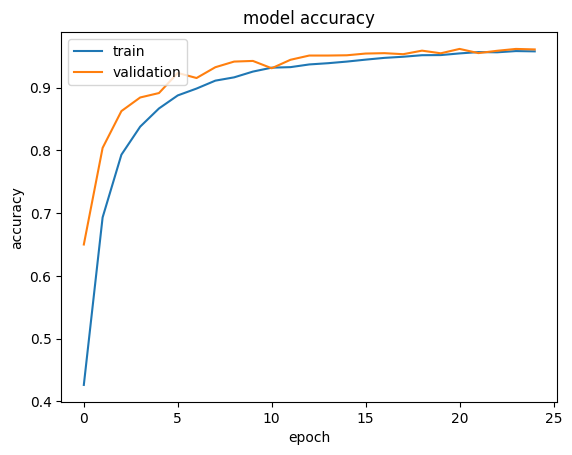

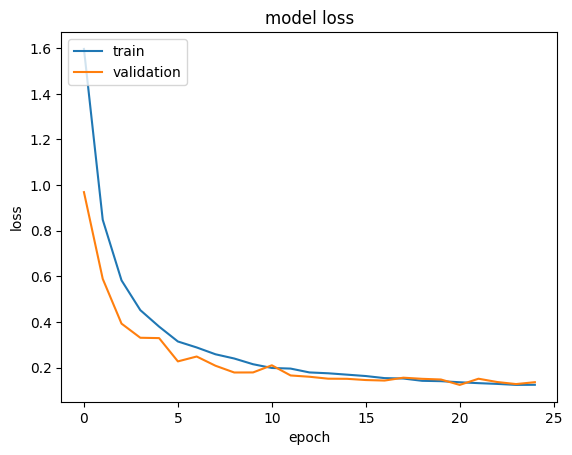

In [19]:
kernel_size = 3

print(f"KERNEL SIZE: {kernel_size}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, kernel_size=kernel_size, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 10m 6.1s

KERNEL SIZE: 5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                        

2024-04-17 11:17:48.374868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 11:17:48.477620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 11:17:48.477814: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 dense_1 (Dense)             (None, 10)                5130      
                                                                 
 activation_5 (Activation)   (None, 10)                0         
                                                                 
Total params: 941098 (3.59 MB)
Trainable params: 941098 (3.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-17 11:17:49.916275: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-17 11:17:50.033447: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 11:17:50.347472: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 29s 22ms/step - loss: 1.5025 - accuracy: 0.4530 - val_loss: 0.8013 - val_accuracy: 0.7102
Epoch 2/25
1221/1221 [==============================] - 25s 21ms/step - loss: 0.7688 - accuracy: 0.7228 - val_loss: 0.4811 - val_accuracy: 0.8345
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.5437 - accuracy: 0.8088 - val_loss: 0.3854 - val_accuracy: 0.8676
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4356 - accuracy: 0.8467 - val_loss: 0.3276 - val_accuracy: 0.8865
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3602 - accuracy: 0.8736 - val_loss: 0.2492 - val_accuracy: 0.9162
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3180 - accuracy: 0.8893 - val_loss: 0.2166 - val_accuracy: 0.9275
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2812 - accuracy: 0.9042 - val_loss: 0.2633 - val_accura

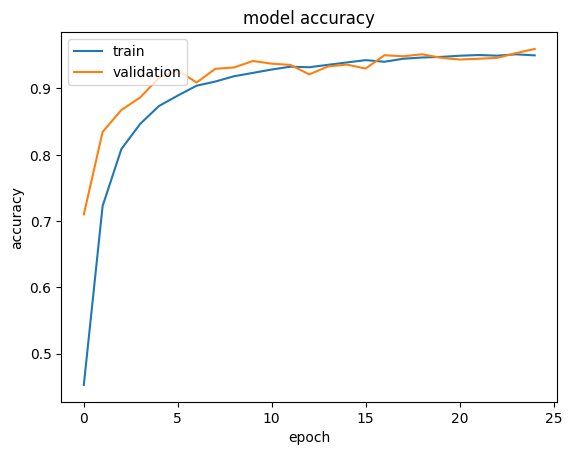

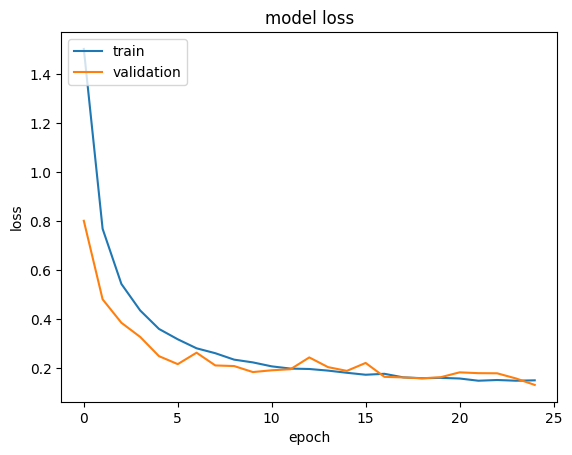

In [19]:
kernel_size = 5

print(f"KERNEL SIZE: {kernel_size}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, kernel_size=kernel_size, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 10m 5.7s

KERNEL SIZE: 7

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        4736      
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        50208     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                        

2024-04-17 12:07:07.941064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 12:07:07.961170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 12:07:07.961284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/25


2024-04-17 12:07:09.327566: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-17 12:07:09.372268: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 12:07:09.581008: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 30s 22ms/step - loss: 1.6329 - accuracy: 0.4029 - val_loss: 1.1310 - val_accuracy: 0.5843
Epoch 2/25
1221/1221 [==============================] - 25s 20ms/step - loss: 1.0494 - accuracy: 0.6097 - val_loss: 0.8314 - val_accuracy: 0.6978
Epoch 3/25
1221/1221 [==============================] - 25s 20ms/step - loss: 0.8113 - accuracy: 0.6997 - val_loss: 0.7203 - val_accuracy: 0.7297
Epoch 4/25
1221/1221 [==============================] - 25s 20ms/step - loss: 0.6715 - accuracy: 0.7566 - val_loss: 0.5572 - val_accuracy: 0.8072
Epoch 5/25
1221/1221 [==============================] - 25s 20ms/step - loss: 0.5740 - accuracy: 0.7913 - val_loss: 0.4852 - val_accuracy: 0.8264
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4881 - accuracy: 0.8252 - val_loss: 0.4459 - val_accuracy: 0.8466
Epoch 7/25
1221/1221 [==============================] - 25s 20ms/step - loss: 0.4331 - accuracy: 0.8446 - val_loss: 0.4156 - val_accura

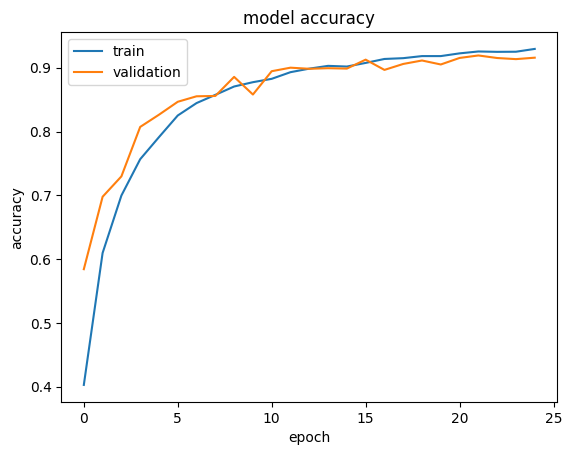

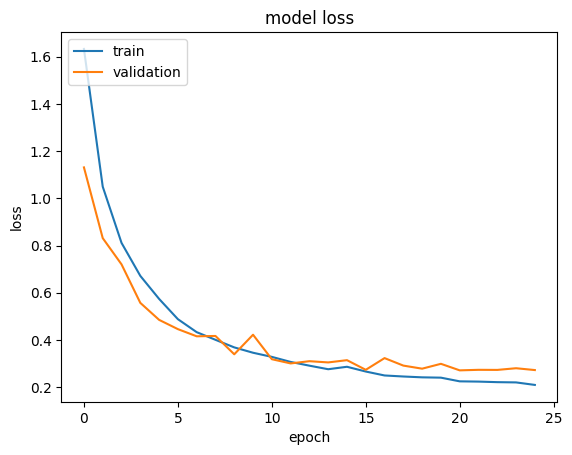

In [20]:
kernel_size = 7

print(f"KERNEL SIZE: {kernel_size}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, kernel_size=kernel_size, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 10m 28.6s

##### Learning Rate Testing (Run Separetly Due to GPU Memory Constraints)

In [17]:
DROPOUT_PERCENTAGE = 0.3 # From testing

LEARNING RATE: 0.1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                    

2024-04-16 18:16:04.185307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:16:04.205190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:16:04.205311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 18:16:05.591390: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 18:16:05.629272: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 18:16:05.807863: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 21ms/step - loss: 185.0918 - accuracy: 0.1051 - val_loss: 2.3099 - val_accuracy: 0.1070
Epoch 2/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3112 - accuracy: 0.1089 - val_loss: 2.3104 - val_accuracy: 0.1080
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3111 - accuracy: 0.1044 - val_loss: 2.3205 - val_accuracy: 0.1060
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3111 - accuracy: 0.1075 - val_loss: 2.3133 - val_accuracy: 0.1060
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3118 - accuracy: 0.1055 - val_loss: 2.3038 - val_accuracy: 0.1080
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3104 - accuracy: 0.1078 - val_loss: 2.3241 - val_accuracy: 0.1070
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3112 - accuracy: 0.1049 - val_loss: 2.3093 - val_accu

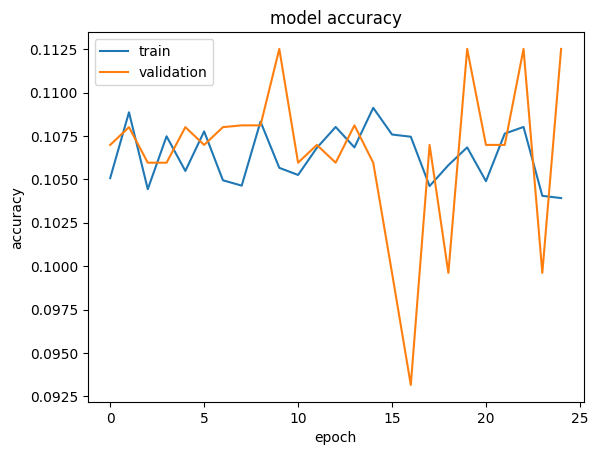

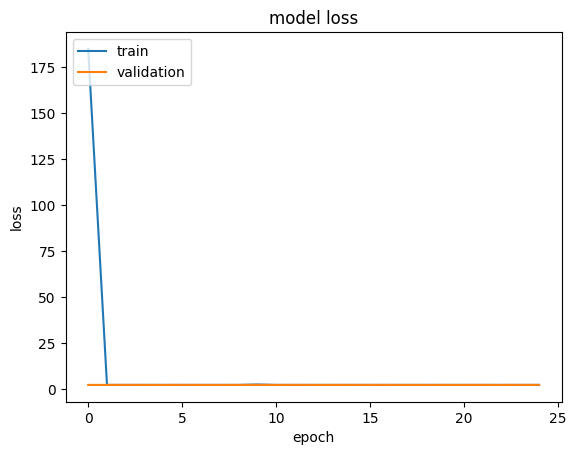

In [19]:
learning_rate = 0.1

print(f"LEARNING RATE: {learning_rate}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

LEARNING RATE: 0.01

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                   

2024-04-16 18:27:44.069725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:27:44.089379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:27:44.089503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 18:27:45.463503: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 18:27:45.502811: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 18:27:45.677577: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 21ms/step - loss: 2.3067 - accuracy: 0.1096 - val_loss: 2.2993 - val_accuracy: 0.1080
Epoch 2/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.2999 - accuracy: 0.1101 - val_loss: 2.3021 - val_accuracy: 0.1125
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.2999 - accuracy: 0.1074 - val_loss: 2.2994 - val_accuracy: 0.1125
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3000 - accuracy: 0.1067 - val_loss: 2.3009 - val_accuracy: 0.1080
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3000 - accuracy: 0.1105 - val_loss: 2.3016 - val_accuracy: 0.1070
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.3000 - accuracy: 0.1100 - val_loss: 2.2999 - val_accuracy: 0.1060
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 2.2999 - accuracy: 0.1092 - val_loss: 2.3000 - val_accura

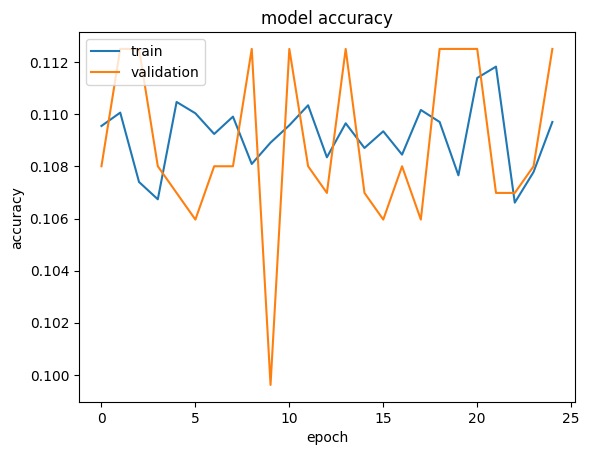

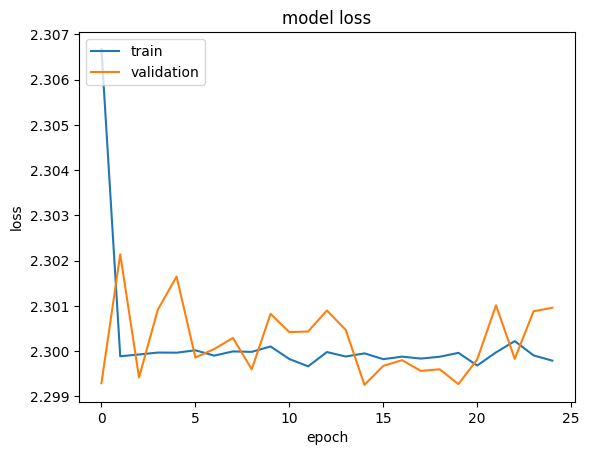

In [19]:
learning_rate = 0.01

print(f"LEARNING RATE: {learning_rate}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

LEARNING RATE: 0.001

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                  

2024-04-16 18:39:02.241905: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:39:02.262405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:39:02.262522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 18:39:03.652902: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 18:39:03.691607: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 18:39:03.890318: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 21ms/step - loss: 1.4142 - accuracy: 0.4902 - val_loss: 0.8091 - val_accuracy: 0.7084
Epoch 2/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.7247 - accuracy: 0.7392 - val_loss: 0.5634 - val_accuracy: 0.7969
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.5077 - accuracy: 0.8178 - val_loss: 0.3870 - val_accuracy: 0.8626
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.4037 - accuracy: 0.8586 - val_loss: 0.2815 - val_accuracy: 0.9082
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.3360 - accuracy: 0.8808 - val_loss: 0.2643 - val_accuracy: 0.9110
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2855 - accuracy: 0.9006 - val_loss: 0.2238 - val_accuracy: 0.9204
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.2587 - accuracy: 0.9103 - val_loss: 0.2108 - val_accura

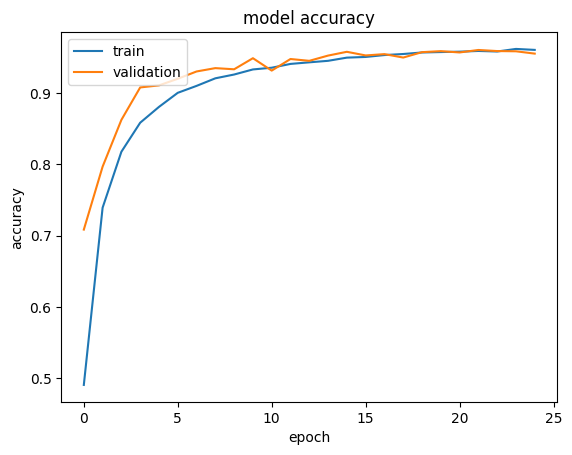

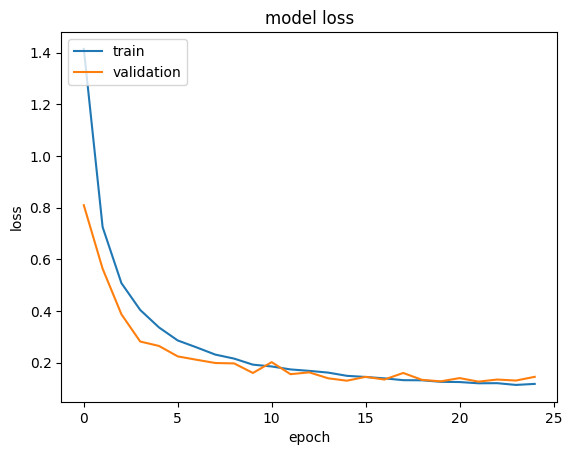

In [19]:
learning_rate = 0.001

print(f"LEARNING RATE: {learning_rate}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

LEARNING RATE: 0.0001

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                 

2024-04-16 18:55:54.703271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:55:54.722657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 18:55:54.722773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 18:55:56.100850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 18:55:56.138298: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 18:55:56.320997: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 27s 21ms/step - loss: 1.9031 - accuracy: 0.3154 - val_loss: 1.4807 - val_accuracy: 0.4905
Epoch 2/25
1221/1221 [==============================] - 24s 20ms/step - loss: 1.3588 - accuracy: 0.5163 - val_loss: 1.1113 - val_accuracy: 0.6132
Epoch 3/25
1221/1221 [==============================] - 24s 20ms/step - loss: 1.1084 - accuracy: 0.6018 - val_loss: 0.9329 - val_accuracy: 0.6762
Epoch 4/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.9424 - accuracy: 0.6654 - val_loss: 0.7604 - val_accuracy: 0.7445
Epoch 5/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.8082 - accuracy: 0.7119 - val_loss: 0.6361 - val_accuracy: 0.7841
Epoch 6/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.7053 - accuracy: 0.7500 - val_loss: 0.5486 - val_accuracy: 0.8152
Epoch 7/25
1221/1221 [==============================] - 24s 20ms/step - loss: 0.6155 - accuracy: 0.7821 - val_loss: 0.4852 - val_accura

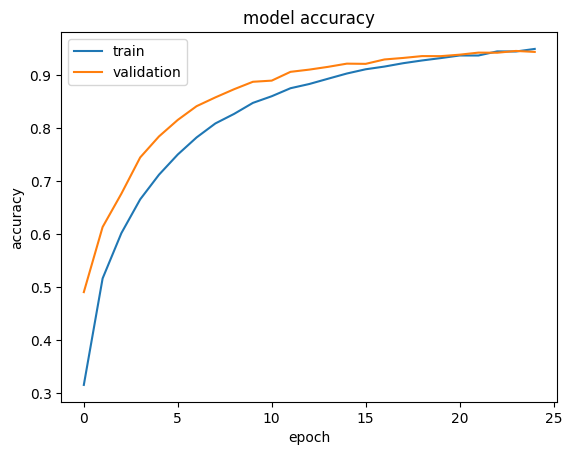

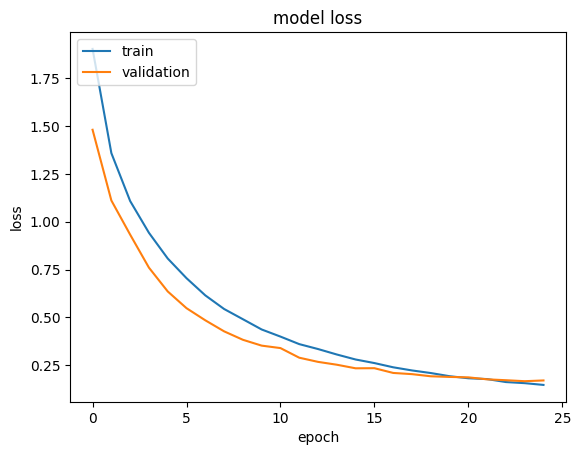

In [19]:
learning_rate = 0.0001

print(f"LEARNING RATE: {learning_rate}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)

##### Batch Size Testing (Run Separetly Due to GPU Memory Constraints)

In [17]:
# From testing
DROPOUT_PERCENTAGE = 0.3 
LEARNING_RATE = 0.001

BATCH SIZE: 32

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                        

2024-04-16 19:16:04.846192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 19:16:04.866077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 19:16:04.866205: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 19:16:06.233897: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 19:16:06.271943: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 19:16:06.452691: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 29s 23ms/step - loss: 1.3992 - accuracy: 0.4944 - val_loss: 0.7899 - val_accuracy: 0.7174
Epoch 2/25
1221/1221 [==============================] - 26s 21ms/step - loss: 0.7104 - accuracy: 0.7444 - val_loss: 0.5147 - val_accuracy: 0.8208
Epoch 3/25
1221/1221 [==============================] - 26s 21ms/step - loss: 0.4934 - accuracy: 0.8262 - val_loss: 0.3234 - val_accuracy: 0.8911
Epoch 4/25
1221/1221 [==============================] - 26s 21ms/step - loss: 0.3862 - accuracy: 0.8643 - val_loss: 0.3007 - val_accuracy: 0.9011
Epoch 5/25
1221/1221 [==============================] - 26s 21ms/step - loss: 0.3146 - accuracy: 0.8900 - val_loss: 0.2146 - val_accuracy: 0.9276
Epoch 6/25
1221/1221 [==============================] - 26s 21ms/step - loss: 0.2772 - accuracy: 0.9040 - val_loss: 0.2101 - val_accuracy: 0.9327
Epoch 7/25
1221/1221 [==============================] - 26s 21ms/step - loss: 0.2433 - accuracy: 0.9154 - val_loss: 0.1814 - val_accura

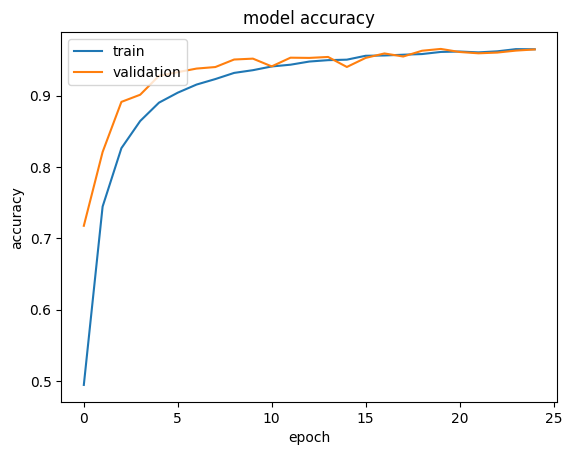

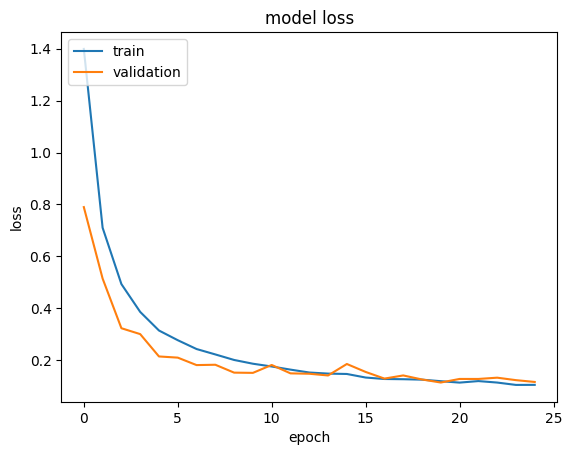

In [21]:
batch_size = 32

print(f"BATCH SIZE: {batch_size}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=batch_size, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 10m 51.7s

BATCH SIZE: 64

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                        

2024-04-16 19:41:18.832808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 19:41:18.852824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 19:41:18.852985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 19:41:20.323191: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 19:41:20.362021: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 19:41:20.573930: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


611/611 [==============================] - 16s 23ms/step - loss: 1.4886 - accuracy: 0.4607 - val_loss: 0.8399 - val_accuracy: 0.7055
Epoch 2/25
611/611 [==============================] - 13s 21ms/step - loss: 0.7664 - accuracy: 0.7247 - val_loss: 0.5178 - val_accuracy: 0.8239
Epoch 3/25
611/611 [==============================] - 13s 21ms/step - loss: 0.5309 - accuracy: 0.8105 - val_loss: 0.3894 - val_accuracy: 0.8727
Epoch 4/25
611/611 [==============================] - 13s 21ms/step - loss: 0.3988 - accuracy: 0.8578 - val_loss: 0.2948 - val_accuracy: 0.9054
Epoch 5/25
611/611 [==============================] - 13s 21ms/step - loss: 0.3232 - accuracy: 0.8848 - val_loss: 0.2413 - val_accuracy: 0.9194
Epoch 6/25
611/611 [==============================] - 13s 21ms/step - loss: 0.2670 - accuracy: 0.9076 - val_loss: 0.2231 - val_accuracy: 0.9258
Epoch 7/25
611/611 [==============================] - 13s 21ms/step - loss: 0.2379 - accuracy: 0.9152 - val_loss: 0.1932 - val_accuracy: 0.9365
Epo

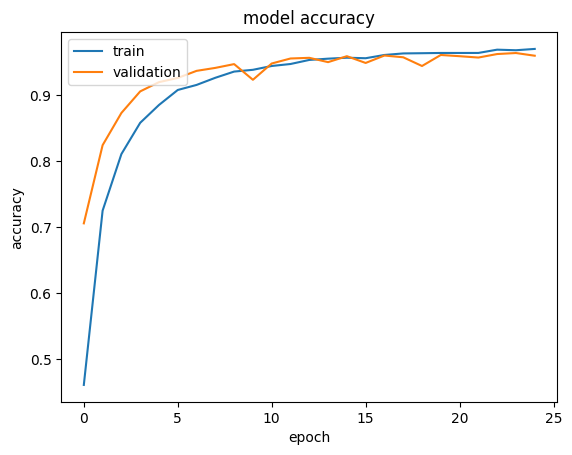

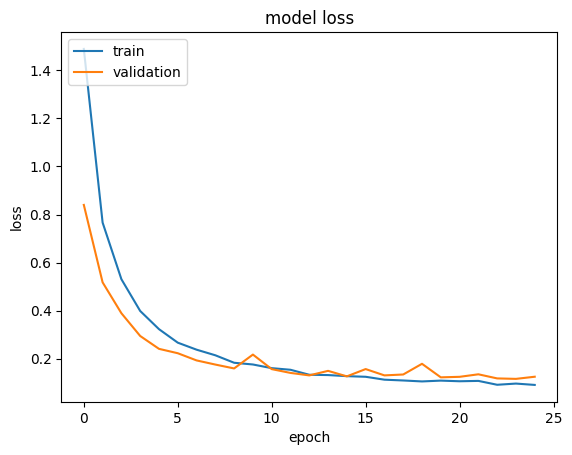

In [19]:
batch_size = 64

print(f"BATCH SIZE: {batch_size}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=batch_size, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 5m 30.7s

BATCH SIZE: 128

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                       

2024-04-16 19:36:21.621597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 19:36:21.641798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 19:36:21.641966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 19:36:23.094396: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 19:36:23.136802: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 19:36:23.404464: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


306/306 [==============================] - 14s 30ms/step - loss: 1.5790 - accuracy: 0.4285 - val_loss: 1.0196 - val_accuracy: 0.6359
Epoch 2/25
306/306 [==============================] - 8s 26ms/step - loss: 0.9095 - accuracy: 0.6727 - val_loss: 0.6921 - val_accuracy: 0.7483
Epoch 3/25
306/306 [==============================] - 8s 25ms/step - loss: 0.6499 - accuracy: 0.7660 - val_loss: 0.4722 - val_accuracy: 0.8410
Epoch 4/25
306/306 [==============================] - 8s 25ms/step - loss: 0.4990 - accuracy: 0.8243 - val_loss: 0.4395 - val_accuracy: 0.8449
Epoch 5/25
306/306 [==============================] - 8s 25ms/step - loss: 0.4024 - accuracy: 0.8579 - val_loss: 0.3249 - val_accuracy: 0.8887
Epoch 6/25
306/306 [==============================] - 8s 25ms/step - loss: 0.3346 - accuracy: 0.8818 - val_loss: 0.2720 - val_accuracy: 0.9084
Epoch 7/25
306/306 [==============================] - 8s 25ms/step - loss: 0.2885 - accuracy: 0.8998 - val_loss: 0.2265 - val_accuracy: 0.9249
Epoch 8/2

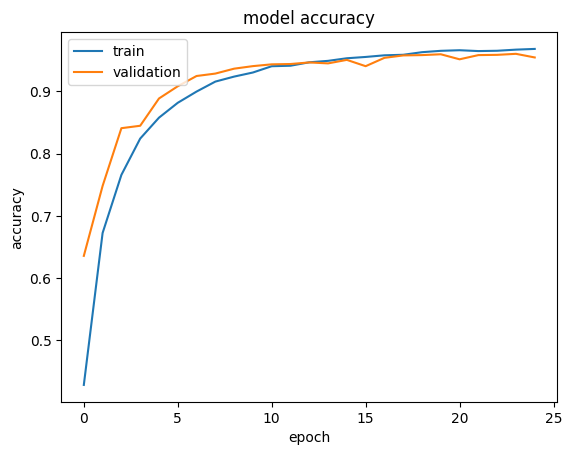

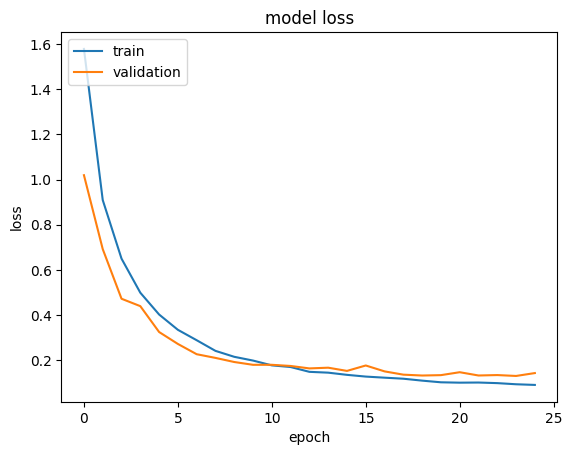

In [19]:
batch_size = 128

print(f"BATCH SIZE: {batch_size}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=batch_size, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 3m 24.5s

BATCH SIZE: 256

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                       

2024-04-16 19:48:25.965494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 19:48:25.986048: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 19:48:25.986170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 19:48:27.493656: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 19:48:27.543314: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 19:48:27.884572: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


153/153 [==============================] - 18s 72ms/step - loss: 1.7854 - accuracy: 0.3567 - val_loss: 1.2486 - val_accuracy: 0.5534
Epoch 2/25
153/153 [==============================] - 6s 41ms/step - loss: 1.0821 - accuracy: 0.6072 - val_loss: 0.7982 - val_accuracy: 0.7172
Epoch 3/25
153/153 [==============================] - 6s 41ms/step - loss: 0.7603 - accuracy: 0.7271 - val_loss: 0.5480 - val_accuracy: 0.8068
Epoch 4/25
153/153 [==============================] - 6s 42ms/step - loss: 0.5874 - accuracy: 0.7920 - val_loss: 0.4534 - val_accuracy: 0.8451
Epoch 5/25
153/153 [==============================] - 6s 42ms/step - loss: 0.4673 - accuracy: 0.8334 - val_loss: 0.3404 - val_accuracy: 0.8837
Epoch 6/25
153/153 [==============================] - 6s 41ms/step - loss: 0.3863 - accuracy: 0.8635 - val_loss: 0.2817 - val_accuracy: 0.9051
Epoch 7/25
153/153 [==============================] - 6s 42ms/step - loss: 0.3417 - accuracy: 0.8783 - val_loss: 0.3106 - val_accuracy: 0.8979
Epoch 8/2

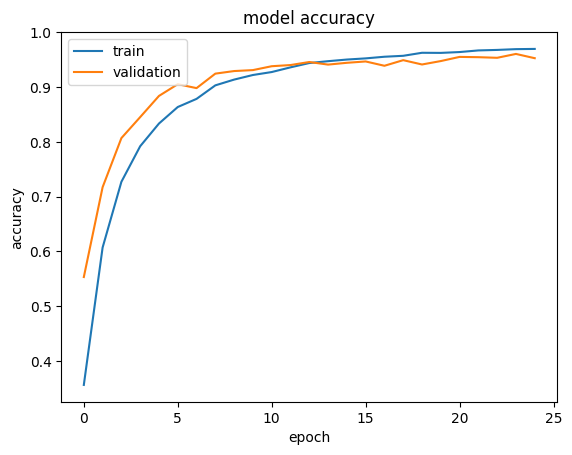

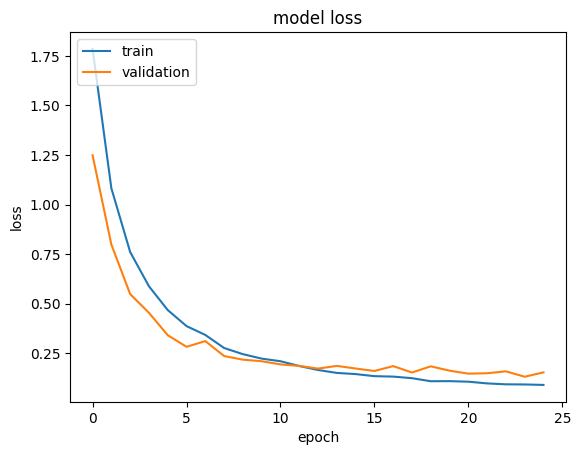

In [19]:
batch_size = 256

print(f"BATCH SIZE: {batch_size}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=batch_size, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 2m 55.6s

BATCH SIZE: 512

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                       

2024-04-16 20:01:38.563959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:01:38.584291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:01:38.584415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 20:01:39.948453: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 20:01:39.986523: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 20:01:40.479371: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 20:01:43.617392: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.67GiB with freed_by_count=0. The caller indicates that this is not a failure, 

77/77 [==============================] - 23s 127ms/step - loss: 1.9535 - accuracy: 0.2964 - val_loss: 1.5346 - val_accuracy: 0.4646
Epoch 2/25
77/77 [==============================] - 5s 69ms/step - loss: 1.3613 - accuracy: 0.5131 - val_loss: 1.1027 - val_accuracy: 0.6098
Epoch 3/25
77/77 [==============================] - 5s 69ms/step - loss: 1.0189 - accuracy: 0.6368 - val_loss: 0.8125 - val_accuracy: 0.7188
Epoch 4/25
77/77 [==============================] - 5s 69ms/step - loss: 0.8035 - accuracy: 0.7127 - val_loss: 0.6220 - val_accuracy: 0.7884
Epoch 5/25
77/77 [==============================] - 5s 69ms/step - loss: 0.6576 - accuracy: 0.7698 - val_loss: 0.4904 - val_accuracy: 0.8343
Epoch 6/25
77/77 [==============================] - 5s 70ms/step - loss: 0.5359 - accuracy: 0.8101 - val_loss: 0.4208 - val_accuracy: 0.8620
Epoch 7/25
77/77 [==============================] - 5s 69ms/step - loss: 0.4666 - accuracy: 0.8357 - val_loss: 0.3919 - val_accuracy: 0.8665
Epoch 8/25
77/77 [====

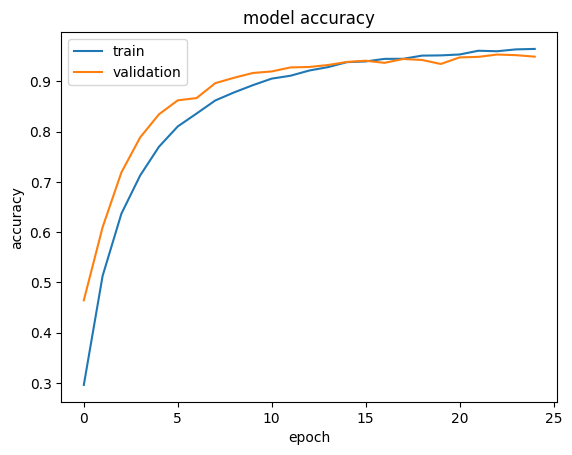

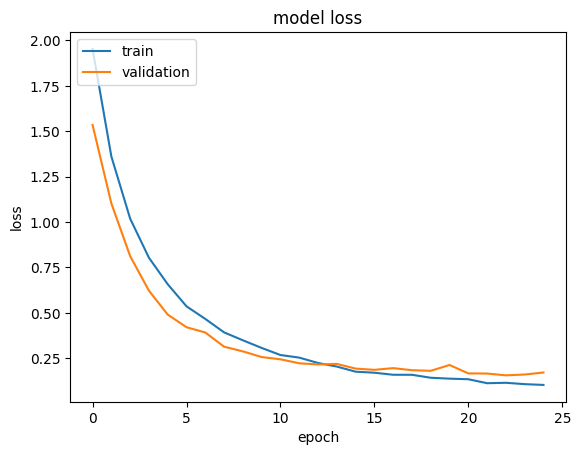

In [20]:
batch_size = 512

print(f"BATCH SIZE: {batch_size}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=batch_size, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 2m 36.1s

##### Epoch Number Testing (Run Separetly Due to GPU Memory Constraints)

In [18]:
# From testing
DROPOUT_PERCENTAGE = 0.3 
LEARNING_RATE = 0.001
BATCH_SIZE = 64

EPOCHS: 25

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                            

2024-04-16 20:12:24.959349: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:12:24.978540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:12:24.978710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Total params: 890410 (3.40 MB)
Trainable params: 890410 (3.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 20:12:26.395430: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 20:12:26.434477: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 20:12:26.654704: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


611/611 [==============================] - 16s 23ms/step - loss: 1.5040 - accuracy: 0.4587 - val_loss: 0.8981 - val_accuracy: 0.6774
Epoch 2/25
611/611 [==============================] - 12s 20ms/step - loss: 0.7862 - accuracy: 0.7190 - val_loss: 0.5553 - val_accuracy: 0.8093
Epoch 3/25
611/611 [==============================] - 12s 20ms/step - loss: 0.5409 - accuracy: 0.8073 - val_loss: 0.3711 - val_accuracy: 0.8727
Epoch 4/25
611/611 [==============================] - 12s 20ms/step - loss: 0.4181 - accuracy: 0.8524 - val_loss: 0.3042 - val_accuracy: 0.8962
Epoch 5/25
611/611 [==============================] - 12s 20ms/step - loss: 0.3417 - accuracy: 0.8808 - val_loss: 0.2567 - val_accuracy: 0.9191
Epoch 6/25
611/611 [==============================] - 12s 20ms/step - loss: 0.2899 - accuracy: 0.8992 - val_loss: 0.2475 - val_accuracy: 0.9172
Epoch 7/25
611/611 [==============================] - 12s 20ms/step - loss: 0.2546 - accuracy: 0.9106 - val_loss: 0.2356 - val_accuracy: 0.9172
Epo

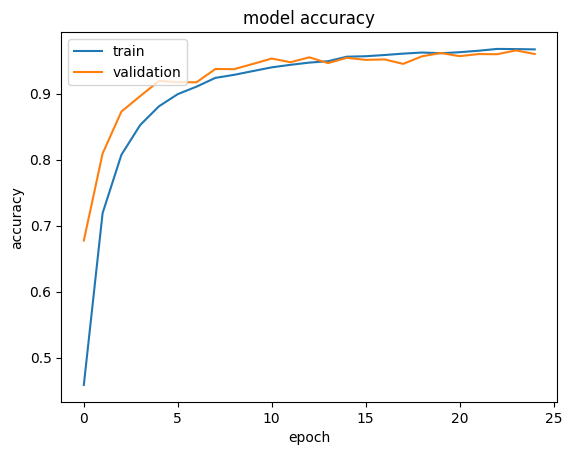

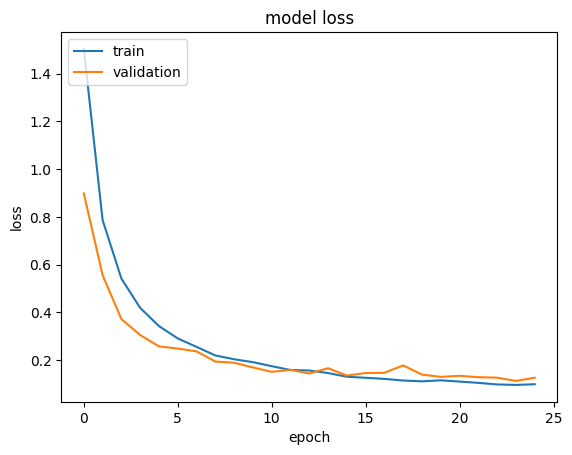

In [19]:
epochs = 25

print(f"EPOCHS: {epochs}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 5m 13.3s

EPOCHS: 50

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                            

2024-04-16 20:18:27.507597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:18:27.526538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:18:27.526831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/50


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 20:18:28.927642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 20:18:28.966587: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 20:18:29.167680: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


611/611 [==============================] - 16s 23ms/step - loss: 1.5378 - accuracy: 0.4462 - val_loss: 0.8906 - val_accuracy: 0.6981
Epoch 2/50
611/611 [==============================] - 12s 20ms/step - loss: 0.8184 - accuracy: 0.7050 - val_loss: 0.5338 - val_accuracy: 0.8221
Epoch 3/50
611/611 [==============================] - 12s 20ms/step - loss: 0.5516 - accuracy: 0.8039 - val_loss: 0.4380 - val_accuracy: 0.8488
Epoch 4/50
611/611 [==============================] - 12s 20ms/step - loss: 0.4205 - accuracy: 0.8511 - val_loss: 0.3004 - val_accuracy: 0.8994
Epoch 5/50
611/611 [==============================] - 12s 20ms/step - loss: 0.3471 - accuracy: 0.8779 - val_loss: 0.2627 - val_accuracy: 0.9134
Epoch 6/50
611/611 [==============================] - 12s 20ms/step - loss: 0.2923 - accuracy: 0.8962 - val_loss: 0.2282 - val_accuracy: 0.9212
Epoch 7/50
611/611 [==============================] - 12s 20ms/step - loss: 0.2537 - accuracy: 0.9099 - val_loss: 0.2124 - val_accuracy: 0.9290
Epo

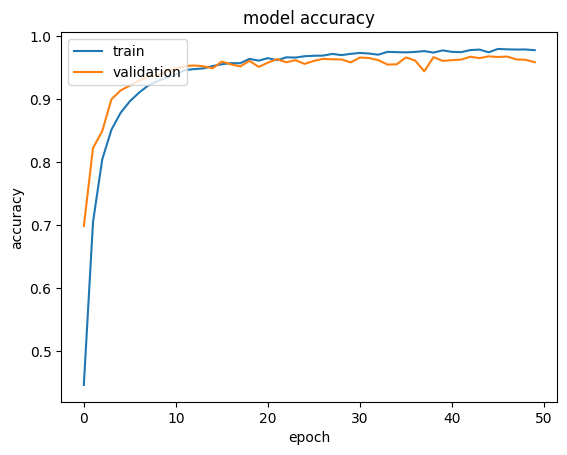

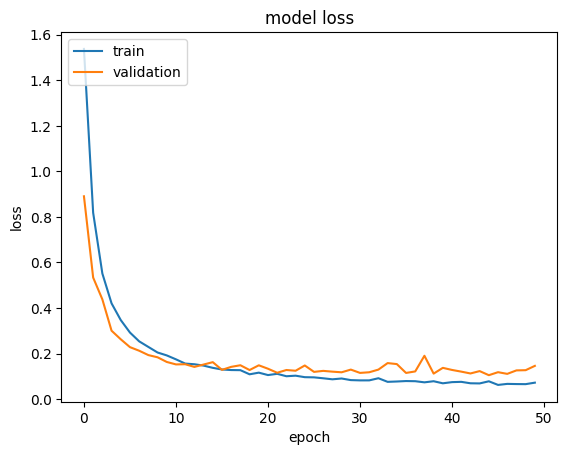

In [19]:
epochs = 50

print(f"EPOCHS: {epochs}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 10m 23.0s

EPOCHS: 75

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                            

2024-04-16 20:29:47.190328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:29:47.210009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:29:47.210167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
 activation_5 (Activation)   (None, 10)                0         
                                                                 
Total params: 890410 (3.40 MB)
Trainable params: 890410 (3.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/75


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 20:29:48.599597: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 20:29:48.639071: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 20:29:48.847766: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


611/611 [==============================] - 16s 22ms/step - loss: 1.4375 - accuracy: 0.4840 - val_loss: 0.8140 - val_accuracy: 0.7112
Epoch 2/75
611/611 [==============================] - 12s 20ms/step - loss: 0.7395 - accuracy: 0.7332 - val_loss: 0.4784 - val_accuracy: 0.8361
Epoch 3/75
611/611 [==============================] - 12s 20ms/step - loss: 0.5024 - accuracy: 0.8212 - val_loss: 0.3544 - val_accuracy: 0.8804
Epoch 4/75
611/611 [==============================] - 12s 20ms/step - loss: 0.3878 - accuracy: 0.8618 - val_loss: 0.3192 - val_accuracy: 0.8895
Epoch 5/75
611/611 [==============================] - 12s 20ms/step - loss: 0.3134 - accuracy: 0.8902 - val_loss: 0.2286 - val_accuracy: 0.9255
Epoch 6/75
611/611 [==============================] - 12s 20ms/step - loss: 0.2610 - accuracy: 0.9094 - val_loss: 0.1995 - val_accuracy: 0.9340
Epoch 7/75
611/611 [==============================] - 12s 20ms/step - loss: 0.2214 - accuracy: 0.9218 - val_loss: 0.2126 - val_accuracy: 0.9238
Epo

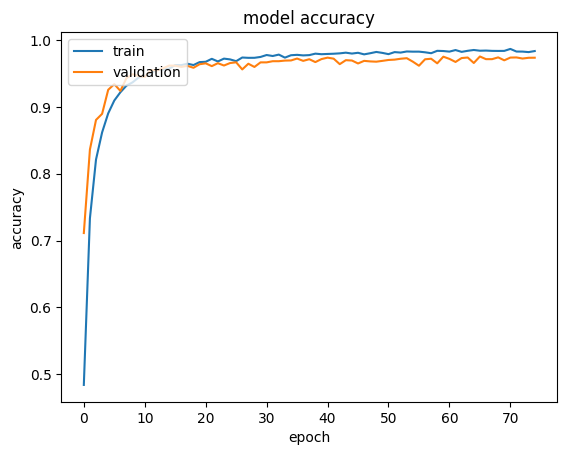

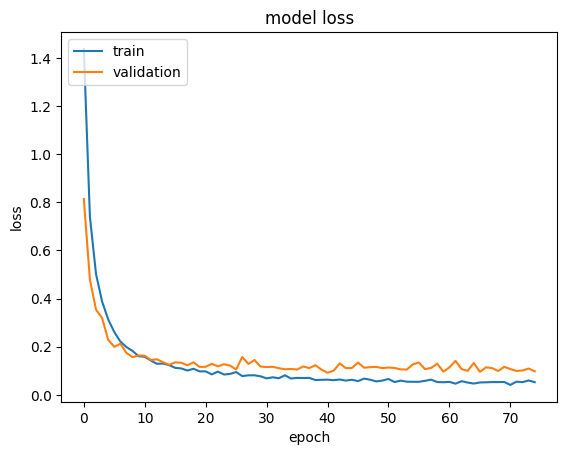

In [19]:
epochs = 75

print(f"EPOCHS: {epochs}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 15m 24.4s

EPOCHS: 100

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                           

2024-04-16 20:46:26.650805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:46:26.669385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:46:26.669502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None
Epoch 1/100


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 20:46:28.060849: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 20:46:28.098562: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 20:46:28.303689: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


611/611 [==============================] - 16s 22ms/step - loss: 1.4778 - accuracy: 0.4670 - val_loss: 0.9197 - val_accuracy: 0.6715
Epoch 2/100
611/611 [==============================] - 12s 20ms/step - loss: 0.7857 - accuracy: 0.7165 - val_loss: 0.5422 - val_accuracy: 0.8116
Epoch 3/100
611/611 [==============================] - 12s 20ms/step - loss: 0.5573 - accuracy: 0.8010 - val_loss: 0.3756 - val_accuracy: 0.8752
Epoch 4/100
611/611 [==============================] - 12s 20ms/step - loss: 0.4261 - accuracy: 0.8471 - val_loss: 0.3113 - val_accuracy: 0.8937
Epoch 5/100
611/611 [==============================] - 12s 20ms/step - loss: 0.3496 - accuracy: 0.8761 - val_loss: 0.2526 - val_accuracy: 0.9167
Epoch 6/100
611/611 [==============================] - 12s 20ms/step - loss: 0.2925 - accuracy: 0.8972 - val_loss: 0.2435 - val_accuracy: 0.9189
Epoch 7/100
611/611 [==============================] - 12s 20ms/step - loss: 0.2613 - accuracy: 0.9077 - val_loss: 0.2361 - val_accuracy: 0.92

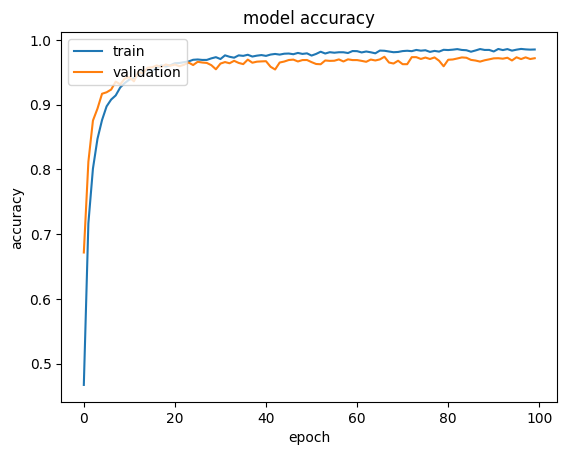

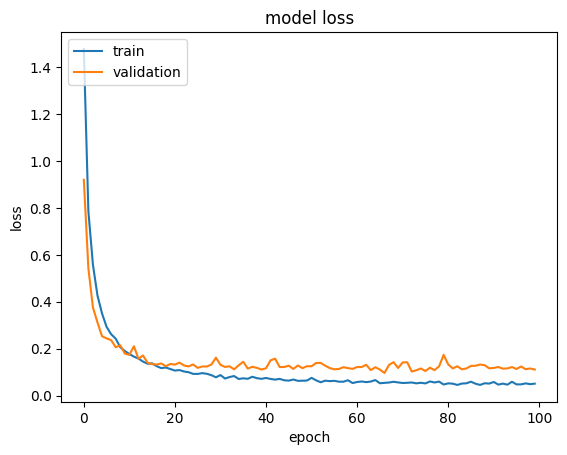

In [19]:
epochs = 100

print(f"EPOCHS: {epochs}\n")

model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES, dropout=DROPOUT_PERCENTAGE)
model.compile(loss="categorical_crossentropy", optimizer=Adam(LEARNING_RATE), metrics=["accuracy"])
print(model.summary())

history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
accuracy = model_evaluation(model, history)
# 20m 31.0s